In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point
import seaborn as sns
%matplotlib inline

In [2]:
# Shim to download the dataset being used here, if it has not been downloaded already.
# cf. https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95
import os

if not os.path.isfile("../data/nyc_collisions/NYPD_Motor_Vehicle_Collisions.csv"):
    import requests
    with open("../data/NYPD Motor Vehicle Collisions.csv", "w") as f:
        f.write(requests.get("https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD").text)

In [3]:
cdata = pd.read_csv("../data/nyc_collisions/NYPD_Motor_Vehicle_Collisions.csv", index_col=0)

def pointify(srs):
    lat, long = srs['LATITUDE'], srs['LONGITUDE']
    if pd.isnull(lat) or pd.isnull(long):
        return Point(0, 0)
    else:
        return Point(lat, long)

collisions = gpd.GeoDataFrame(cdata.head(1000), geometry=cdata.head(1000).apply(pointify, axis='columns'))
collisions = collisions[collisions.geometry.map(lambda srs: not (srs.x == 0))]

del cdata

Original extent:  (-180.0, 180.0, -90.0, 90.0)
Extent after adding KDE:  (40.42536533391019, 40.989181166089814, -74.32880518280508, -73.6337301171949)
Bounds to be used for re-setting extent again:  (40.505369000000002, 40.909177500000006, -74.245621999999997, -73.716913299999987)
New plot extent:  (114.43197801520002, 114.8357865152, -74.245622, -73.71691329999999)


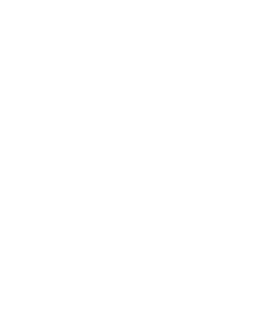

In [4]:
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=-73.9266090152))
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
print("Original extent: ", ax.get_extent())
sns.reset_orig()
sns.kdeplot(pd.Series([p.x for p in collisions.geometry]), pd.Series([p.y for p in collisions.geometry]), ax=ax)
print("Extent after adding KDE: ", ax.get_extent())
# At this point the plot is working as expected. But what if we then attempt to set extent ourselves?

xs = np.array([p.x for p in collisions.geometry])
ys = np.array([p.y for p in collisions.geometry])
print("Bounds to be used for re-setting extent again: ", (np.min(xs), np.max(xs), np.min(ys), np.max(ys)))
ax.set_extent((np.min(xs), np.max(xs), np.min(ys), np.max(ys)), crs=ccrs.PlateCarree())
print("New plot extent: ", ax.get_extent())
# These last two values don't match at all. This is an error!